# 光栅数据

栅格数据模型使用单元格数组或像素来表示真实世界的对象。光栅数据集通常用于表示和管理图像、表面温度、数字高程模型和许多其他实体。栅格可以被认为是区域对象的一种特殊情况，其中区域被划分为规则的单元格网格。但是，有规律间隔的标记点数组可能是更好的类比，因为栅格存储为值数组，其中每个单元格在大多数 GIS 环境中由单个坐标对定义。在栅格数据模型中隐含着一个与每个单元格或像素相关的值。这与向量模型相反，向量模型可能具有或不具有与几何原语相关的值。

为了处理光栅数据，将使用 `rasterio` 和稍后的 `geowombat`。幕后是 `numpy.ndarray` 做了所有繁重的工作。为了理解栅格是如何工作的，它有助于从零开始构建栅格。

这里创建了两个 ndarray 对象，一个 X 跨越经度（longitude） $[-90°，90°]$，另一个 Y 跨越纬度（latitude） $[-90°，90°]$。

In [1]:
import numpy as np
x = np.linspace(-90, 90, 6)
y = np.linspace(-90, 90, 6)
X, Y = np.meshgrid(x, y)
X

array([[-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.]])

生成一些表示温度的数据并将其存储在数组 `Z` 中：

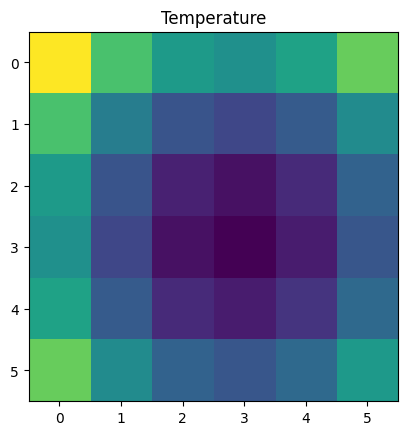

In [2]:
from matplotlib import pyplot as plt

Z1 =  np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 =  np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z =  (Z1 - Z2)

plt.imshow(Z)
plt.title("Temperature")
plt.show()

注意，`Z` 不包含关于其位置的数据。它只是数组，存储在 `x` 和 `y` 中的信息与它完全没有关联。这些位置数据通常存储在文件头文件中。为了在地图上“定位”数组，将使用仿射变换。

## 为数组分配空间数据

好的，我们有一个数据数组和每个单元格的一些坐标，但是我们如何从中创建一个空间数据集呢？为了做到这一点，我们需要三个组成部分：

- 数据数组，通常是 xy 坐标
- 一种坐标参考系统，它定义了我们所使用的坐标空间（例如度或米，本初子午线的位置等）
- 定义左上角坐标和单元格分辨率（resolution）的变换

一旦有了这些组件，就可以在几行代码中用 python 编写出工作的空间栅格数据集。只需要以 `rasterio` 能够理解的格式提供上面列出的信息。

In [5]:
from rasterio.transform import Affine
import rasterio as rio

res = (x[-1] - x[0]) / 240.0
transform = Affine.translation(x[0] - res / 2, y[0] - res / 2) * Affine.scale(res, res)

# open in 'write' mode, unpack profile info to dst
with rio.open(
   "./new_raster.tif",
   "w",
   driver="GTiff",         # output file type
   height=Z.shape[0],      # shape of array
   width=Z.shape[1],
   count=1,                # number of bands
   dtype=Z.dtype,          # output datatype
   crs="+proj=latlong",    # CRS
   transform=transform,    # location and resolution of upper left cell
) as dst:
   # check for number of bands
   if dst.count == 1:
       # write single band
       dst.write(Z, 1)
   else:
       # write each band individually
       for band in range(len(Z)):
           # write data, band # (starting from 1)
           dst.write(Z[band], band + 1)

```{note}
光栅数据通常是“多波段”（multiband）的（如红、绿、蓝），所以这里提供了多波段和单波段数据都适用的代码。

如果存储的是多波段数据，则维度应该存储为 `(band, y, x )`。
```